In [275]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from langgraph.types import CachePolicy
from langgraph.cache.memory import InMemoryCache
from datetime import datetime
from typing import Annotated

In [276]:
def update_function(old, new):
    return old + new


class InputState(TypedDict):
    hello: Annotated[list[str], update_function]

class State(TypedDict):
    seed: int

graph_builder = StateGraph(State)


In [277]:
def node_one(state: State) -> State:
    print("node1: ", state)
    return state


def node_two(state: State) -> State:
    print("node2: ", state)
    return state



def node_three(state: State) -> State:
    print("node3: ", state)
    return state



def node_four(state: State) -> State:
    print("node4: ", state)
    return state

In [278]:
graph_builder.add_node("node_one", node_one)
graph_builder.add_node("node_two", node_two)
graph_builder.add_node("node_three", node_three)
graph_builder.add_node("node_four", node_four)

def decide_path(state: State) -> bool:
    return state["seed"] % 2 == 0

graph_builder.add_edge(START, "node_one")
graph_builder.add_conditional_edges("node_one", decide_path, {
    True : "node_two",
    False: "node_four"
})
graph_builder.add_edge("node_two", "node_three")
graph_builder.add_edge("node_three", "node_four")
graph_builder.add_edge("node_four", END)


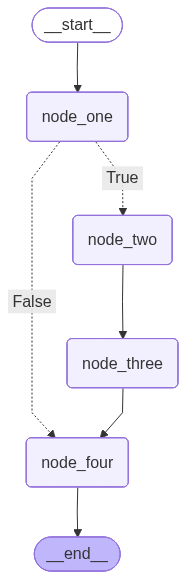

node1:  {'seed': 2}
node2:  {'seed': 2}
node3:  {'seed': 2}
node4:  {'seed': 2}
result: {'seed': 2}


In [279]:
graph = graph_builder.compile(cache=InMemoryCache())
display(graph)
# print(graph.get_graph().draw_ascii())



import time

result = graph.invoke({
    "seed": 2,
})
print("result:", result)